In [3]:
import pandas as pd

In [5]:
import geopandas as gpd

In [7]:
import os

In [9]:
import matplotlib.pyplot as plt
from osgeo import gdal, osr

In [ ]:
########## Reading REE mineralization file #####

In [11]:
df_ree_min = gpd.read_file("ree_critical_min_ngdr_20250425115327129/ree_critical_min_ngdr_20250425115327129.shp")

In [15]:
df_ree_min.to_crs("EPSG:32643", inplace=True)

In [17]:
df_ree_min

gid  objectid          locality region           state toposheet commodity  \
0    6         6  Chetlamallapuram     SR  Andhra Pradesh  57E10,14       REE   

  resource reserve grade remarks                         age host_rock  \
0     None    None  None    None  Archaean-Palaeoproterozoic   Granite   

   longitude  latitude           geology                  morphometr  \
0      77.75    15.616  Closepet Granite  REE/RM in Igneous coplexes   

   occurrence                        geometry  
0  Occurrence  POINT (794879.657 1728366.191)

<Axes: >

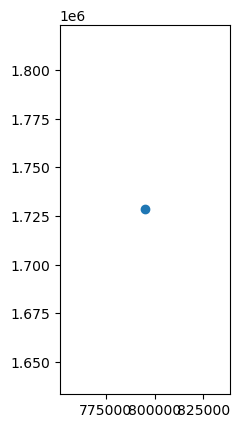

In [19]:
df_ree_min.plot()

In [23]:
df_ree_min.to_file("ree_deposit.shp")

In [ ]:
##### Reading the carbonatite shape file  #####

In [19]:
import geopandas as gpd
df_carbonate = gpd.read_file("GEOTIFF_REE/carbonated like shp at 1000m_pt.shp")

In [245]:
df_carbonate.to_crs("EPSG:32643", inplace=True)

<Axes: >

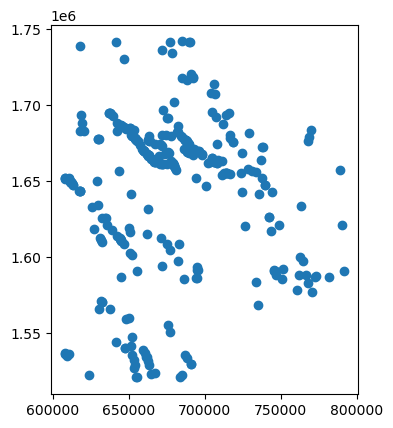

In [247]:
df_carbonate.plot()

In [ ]:
##### Making the combined NGCM layer for REE ##########

CRS: EPSG:32643
Bounds: BoundingBox(left=607500.0, bottom=1520700.0, right=797100.0, top=1743300.0)


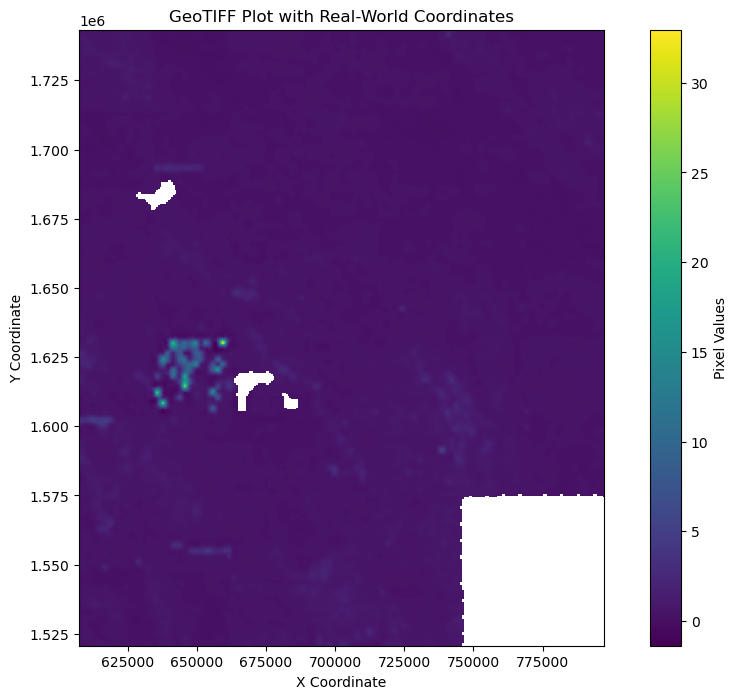

In [9]:
import rasterio
import numpy as np
with rasterio.open('GEOTIFF_REE/GEOCHEM/NGCM_Tm_ppm.tif') as src:
    raster_data = src.read(1)  
    nodata = src.nodata
    bounds = src.bounds  
    if nodata is not None:
        raster_data = np.where(raster_data == nodata, np.nan, raster_data)
    crs = src.crs         
    print(f"CRS: {crs}")
    print(f"Bounds: {bounds}")

    
    plt.figure(figsize=(12, 8))
    plt.imshow(
        raster_data,
        cmap='viridis',
        extent=[bounds.left, bounds.right, bounds.bottom, bounds.top]
    )
    plt.colorbar(label='Pixel Values')
    plt.title('GeoTIFF Plot with Real-World Coordinates')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

In [87]:
import os
import numpy as np
import pandas as pd
import rasterio

folder_path = "GEOTIFF_REE/GEOCHEM/"

data_dict = {}

for filename in os.listdir(folder_path):
    if filename.lower().endswith((".tif", ".tiff")):
        file_path = os.path.join(folder_path, filename)
        
        with rasterio.open(file_path) as src:
            band = src.read(1)
            nodata = src.nodata
            transform = src.transform
            
            if nodata is not None:
                band = np.where(band == nodata, np.nan, band)
            
            rows, cols = np.meshgrid(np.arange(band.shape[0]), 
                                     np.arange(band.shape[1]), 
                                     indexing='ij')
            
            xs, ys = rasterio.transform.xy(transform, rows, cols)
            x_flat = np.array(xs).flatten()
            y_flat = np.array(ys).flatten()
            band_flat = band.flatten()
            
            #
            df = pd.DataFrame({
                'X': x_flat,
                'Y': y_flat,
                filename: band_flat
            })
            
            
            data_dict[filename] = df


df_merged = None
for i, df in enumerate(data_dict.values()):
    if i == 0:
        df_merged = df
    else:
        df_merged = pd.merge(df_merged, df, on=['X', 'Y'], how='outer')


df_merged.columns = ['X', 'Y'] + [col.replace('.tif', '').replace('.tiff', '') for col in df_merged.columns[2:]]


In [89]:
df_merged

X          Y  NGCM_Gd_ppm  NGCM_Tb_iwd  NGCM_Tm_ppm  \
0        607550.0  1520750.0          NaN          NaN     0.299987   
1        607550.0  1520850.0          NaN          NaN     0.299987   
2        607550.0  1520950.0          NaN          NaN     0.299987   
3        607550.0  1521050.0          NaN          NaN     0.299987   
4        607550.0  1521150.0          NaN          NaN     0.299987   
...           ...        ...          ...          ...          ...   
4220491  797050.0  1742850.0          NaN          NaN     0.265557   
4220492  797050.0  1742950.0          NaN          NaN     0.265557   
4220493  797050.0  1743050.0          NaN          NaN     0.265557   
4220494  797050.0  1743150.0          NaN          NaN     0.265557   
4220495  797050.0  1743250.0          NaN          NaN     0.265557   

         NGCM_Ho_ppm  NGCM_y_ppm  NGCM_Dy_ppm  NGCM_Er_ppm  NGCM_Lu_ppm  
0           0.546283    2.134220     2.939044     1.828556     0.346104  
1           0.546283    2.134220     2.939044     1.828556     0.346104  
2           0.546283    2.134220     2.939044     1.828556     0.346104  
3           0.546283    2.134220     2.939044     1.828556     0.346104  
4           0.546283    2.134220     2.939044     1.828556     0.346104  
...              ...         ...          ...          ...          ...  
4220491     0.631954    1.899943     2.580106     1.514068     0.281514  
4220492     0.631954    1.899943     2.580106     1.514068     0.281514  
4220493     0.631954    1.899943     2.580106     1.514068     0.281514  
4220494     0.631954    1.899943     2.580106     1.514068     0.281514  
4220495     0.631954    1.899943     2.580106     1.514068     0.281514  

[4220496 rows x 10 columns]

In [115]:
df_merged['NGCM_Tm_ppm'].max()

32.95271682739258

In [67]:
df_merged.replace(np.nan,0,inplace=True)

<Axes: >

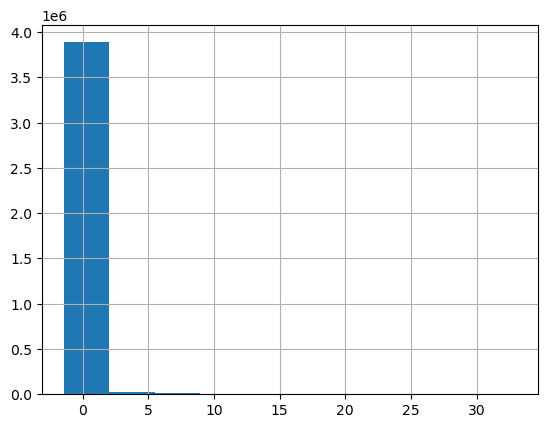

In [113]:
df_merged['NGCM_Tm_ppm'].hist(bins=10)

In [117]:
import pandas as pd


df_merged['Tm_class'] = 0

# Assign the value 1 where the condition is met
df_merged.loc[(df_merged['NGCM_Tm_ppm'] >= 0) & (df_merged['NGCM_Tm_ppm'] < 5), 'Tm_class'] = 1
df_merged.loc[(df_merged['NGCM_Tm_ppm'] >= 5) & (df_merged['NGCM_Tm_ppm'] < 10), 'Tm_class'] = 2
df_merged.loc[(df_merged['NGCM_Tm_ppm'] >= 10) & (df_merged['NGCM_Tm_ppm'] < 15), 'Tm_class'] = 3
df_merged.loc[(df_merged['NGCM_Tm_ppm'] >= 15) & (df_merged['NGCM_Tm_ppm'] < 20), 'Tm_class'] = 4
df_merged.loc[(df_merged['NGCM_Tm_ppm'] >= 20) & (df_merged['NGCM_Tm_ppm'] < 25), 'Tm_class'] = 5
df_merged.loc[(df_merged['NGCM_Tm_ppm'] >= 25) & (df_merged['NGCM_Tm_ppm'] < 30), 'Tm_class'] = 6
df_merged.loc[(df_merged['NGCM_Tm_ppm'] >= 30), 'Tm_class'] = 7


<Axes: >

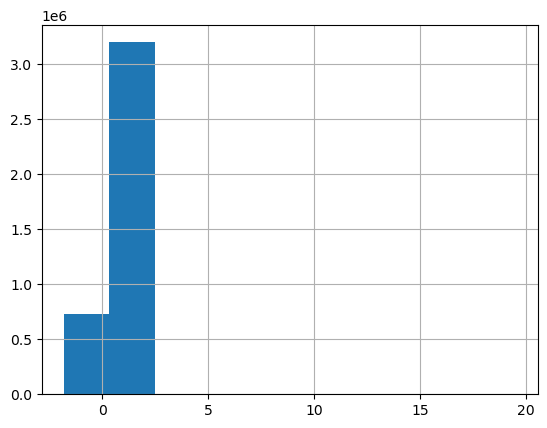

In [145]:
df_merged['NGCM_Lu_ppm'].hist()

In [147]:
import pandas as pd


df_merged['Lu_class'] = 0

# Assign the value 1 where the condition is met
df_merged.loc[(df_merged['NGCM_Lu_ppm'] >= 0) & (df_merged['NGCM_Lu_ppm'] < 5), 'Lu_class'] = 1
df_merged.loc[(df_merged['NGCM_Lu_ppm'] >= 5) & (df_merged['NGCM_Lu_ppm'] < 10), 'Lu_class'] = 2
df_merged.loc[(df_merged['NGCM_Lu_ppm'] >= 10) & (df_merged['NGCM_Lu_ppm'] < 15), 'Lu_class'] = 3
df_merged.loc[(df_merged['NGCM_Lu_ppm'] >= 15) & (df_merged['NGCM_Lu_ppm'] < 20), 'Lu_class'] = 4
df_merged.loc[(df_merged['NGCM_Lu_ppm'] >= 20) , 'Lu_class'] = 5


In [183]:
df_merged['combined_class'] = df_merged['Tm_class']+df_merged['Ho_class']+df_merged['y_class']+df_merged['Dy_class']+df_merged['Er_class']+df_merged['Lu_class']

In [185]:
df_merged['combined_class'] = (
    df_merged['combined_class'] - df_merged['combined_class'].min()
) / (df_merged['combined_class'].max() - df_merged['combined_class'].min())


In [187]:
df_merged['combined_class']

0          0.1875
1          0.1875
2          0.1875
3          0.1875
4          0.1875
            ...  
4220491    0.1875
4220492    0.1875
4220493    0.1875
4220494    0.1875
4220495    0.1875
Name: combined_class, Length: 4220496, dtype: float64

In [189]:
df_merged_gpd = gpd.GeoDataFrame(df_merged, geometry=gpd.points_from_xy(df_merged.X, df_merged.Y), crs="EPSG:32643")

In [191]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin

gdf = df_merged_gpd
value_column = 'combined_class'

pixel_size = 100  
minx, miny, maxx, maxy = df_merged_gpd.total_bounds  
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)
transform = from_origin(minx, maxy, pixel_size, pixel_size)  
out_shape = (height, width)


shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_column]))

raster = rasterize(shapes=shapes, out_shape=out_shape, transform=transform)

with rasterio.open(
    'combined_class_ngcm_ree.tif',
    'w',
    driver='GTiff',
    height=out_shape[0],
    width=out_shape[1],
    count=1,
    dtype=raster.dtype,
    crs=gdf.crs,
    transform=transform
) as dst:
    dst.write(raster, 1)


CRS: EPSG:32643
Bounds: BoundingBox(left=607550.0, bottom=1520750.0, right=797050.0, top=1743250.0)


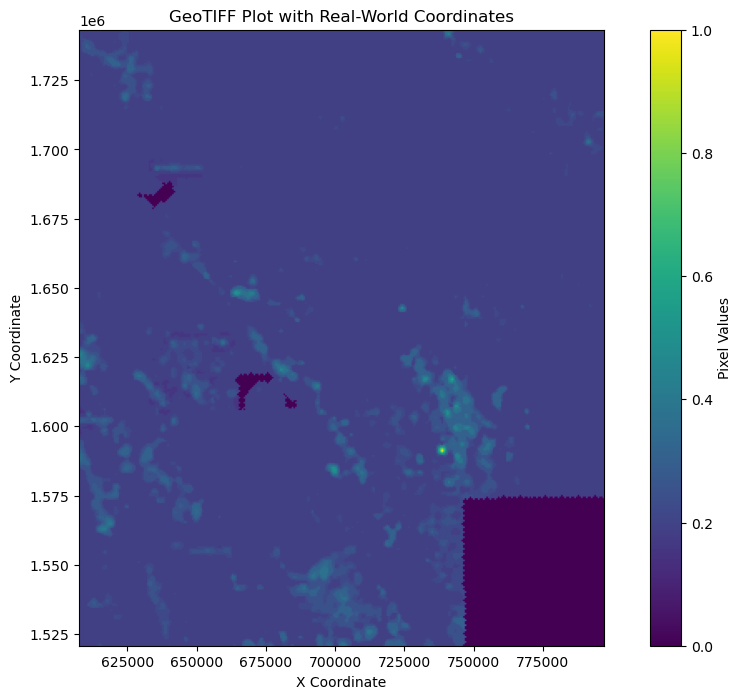

In [193]:
import numpy as np
with rasterio.open('combined_class_ngcm_ree.tif') as src:
    raster_data = src.read(1)  
    nodata = src.nodata
    bounds = src.bounds  
    if nodata is not None:
        raster_data = np.where(raster_data == nodata, np.nan, raster_data)
    crs = src.crs         
    print(f"CRS: {crs}")
    print(f"Bounds: {bounds}")

   
    plt.figure(figsize=(12, 8))
    plt.imshow(
        raster_data,
        cmap='viridis',
        extent=[bounds.left, bounds.right, bounds.bottom, bounds.top]
    )
    plt.colorbar(label='Pixel Values')
    plt.title('GeoTIFF Plot with Real-World Coordinates')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

In [ ]:
##### Making the magnetic lineaments file ###########

In [201]:
df_ds_lineament = gpd.read_file("GEOTIFF_REE/DEEP SEATED LINEAMENT FROM MAG_ln.shp", crs="EPSG:32643")

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option CRS
  return ogr_read(


In [203]:
df_s_lineament = gpd.read_file("GEOTIFF_REE/SHALLOW LINEAMENTS FROM MAG_ln.shp", crs="EPSG:32643")

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option CRS
  return ogr_read(


<Axes: >

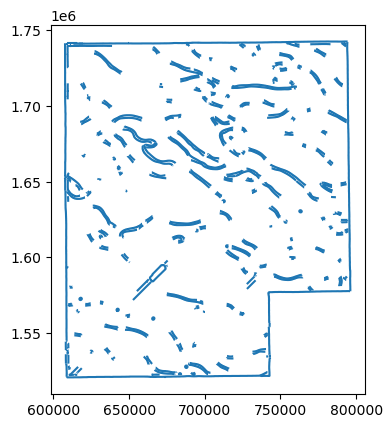

In [209]:
df_ds_lineament.plot()

In [213]:
df_ds_lineament.to_crs("EPSG:32643",inplace=True)
df_s_lineament.to_crs("EPSG:32643",inplace=True)

In [215]:
lines_ds = df_ds_lineament['geometry'].values
lines_s = df_s_lineament['geometry'].values

In [217]:
intersections1 = []

for line1 in lines_ds:
    for line2 in lines_s:
        inter = line1.intersection(line2)
        if not inter.is_empty:
            intersections1.append(inter)

In [ ]:
######## Reading the first merged file #######

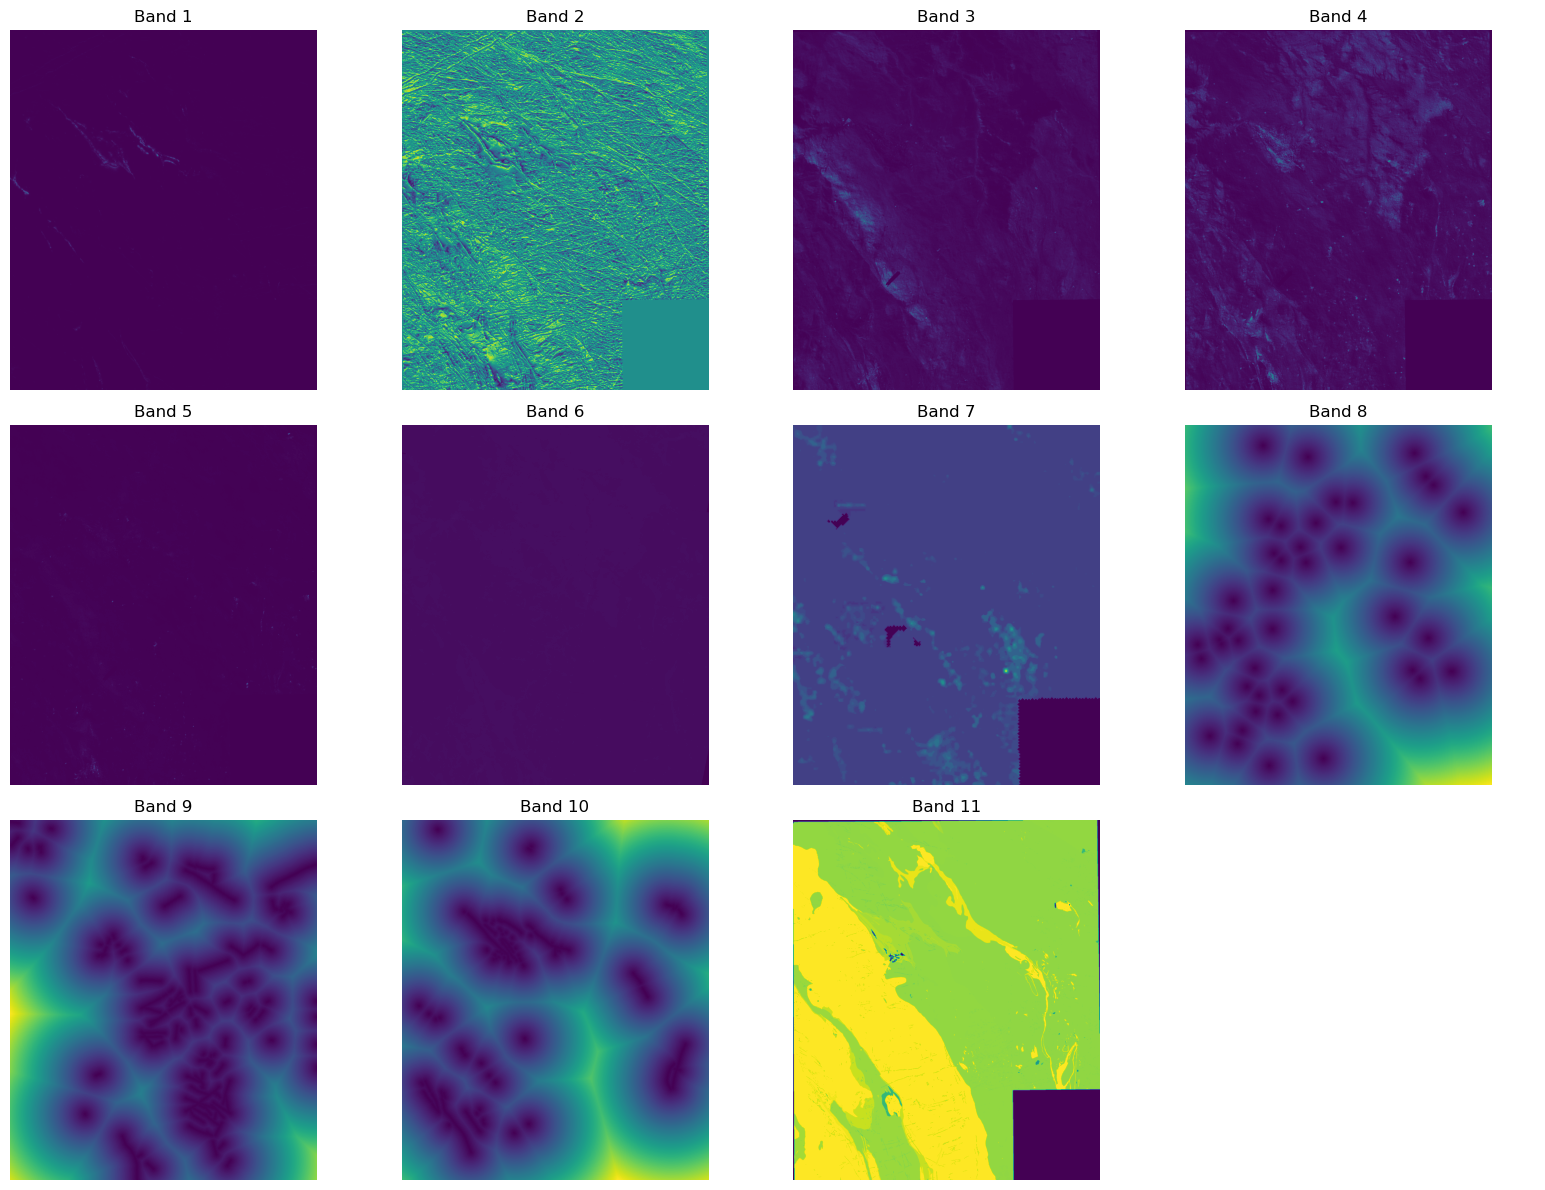

In [223]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

with rasterio.open("GEOTIFF_REE/REE_combined.tif") as src:
    band_count = src.count
    nodata = src.nodata
    bands = []

    for i in range(1, band_count + 1):
        band = src.read(i).astype('float32')  # Convert to float for NaN support
        if nodata is None:
            band = np.where(band == nodata, np.nan, band)
        
        bands.append(band)

cols = 4
rows = int(np.ceil(len(bands) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

for i, band in enumerate(bands):
    r, c = divmod(i, cols)
    ax = axes[r, c] if rows > 1 else axes[c]
    im = ax.imshow(band, cmap="viridis")
    ax.set_title(f"Band {i + 1}")
    ax.axis("off")

for j in range(len(bands), rows * cols):
    r, c = divmod(j, cols)
    ax = axes[r, c] if rows > 1 else axes[c]
    ax.axis("off")

plt.tight_layout()
plt.show()


In [225]:
import rasterio
from rasterio.windows import from_bounds
import numpy as np

xmin, ymin, xmax, ymax = 742386, 1521300, 796417.39, 1578150

with rasterio.open('GEOTIFF_REE/REE_combined.tif', 'r+') as src:
    window = from_bounds(xmin, ymin, xmax, ymax, transform=src.transform)
    
    nodata = src.nodata
    if nodata is None:
        nodata = np.nan  
        src.nodata = nodata


    data = src.read(window=window)
    
    data[:] = nodata
    
    src.write(data, window=window)


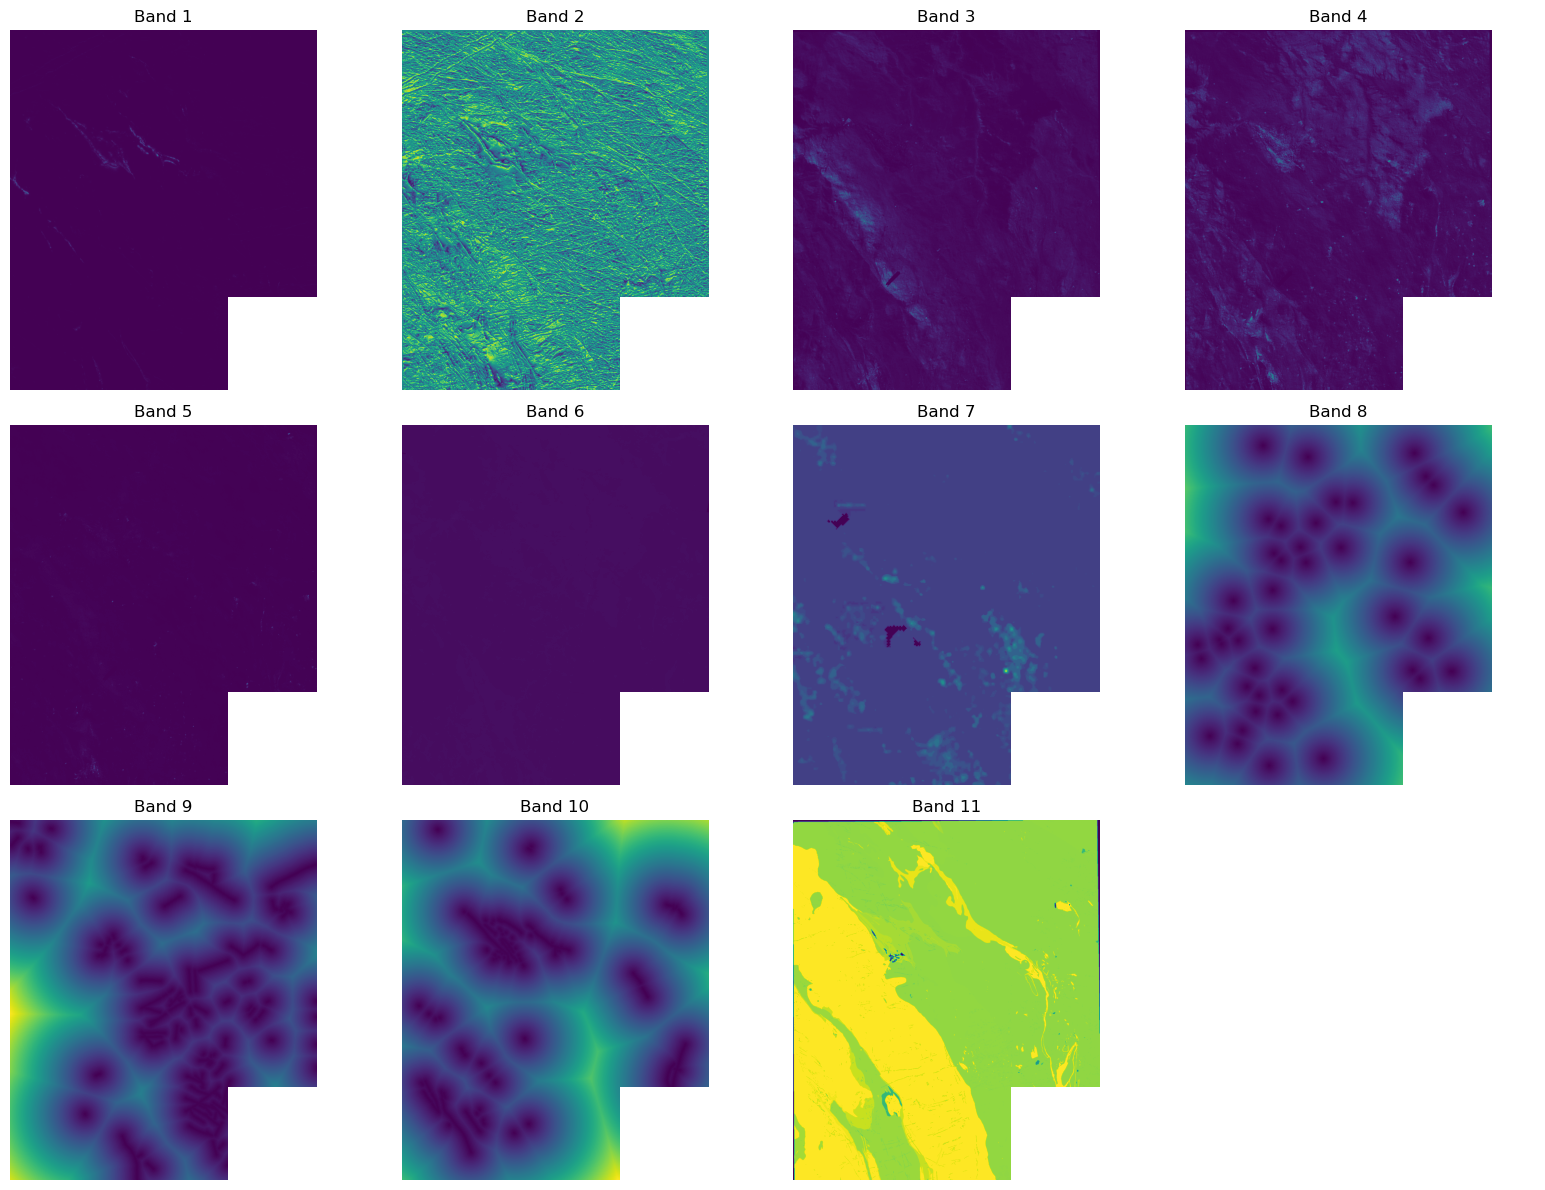

In [227]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

with rasterio.open("GEOTIFF_REE/REE_combined.tif") as src:
    band_count = src.count
    nodata = src.nodata
    bands = []

    for i in range(1, band_count + 1):
        band = src.read(i).astype('float32')  
        if nodata is None:
            band = np.where(band == nodata, np.nan, band)
        
        bands.append(band)

cols = 4
rows = int(np.ceil(len(bands) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

for i, band in enumerate(bands):
    r, c = divmod(i, cols)
    ax = axes[r, c] if rows > 1 else axes[c]
    im = ax.imshow(band, cmap="viridis")
    ax.set_title(f"Band {i + 1}")
    ax.axis("off")

for j in range(len(bands), rows * cols):
    r, c = divmod(j, cols)
    ax = axes[r, c] if rows > 1 else axes[c]
    ax.axis("off")

plt.tight_layout()
plt.show()


In [229]:
import rasterio
import pandas as pd
from rasterio.transform import xy
import numpy as np

with rasterio.open("GEOTIFF_REE/REE_combined.tif") as src:
    band_count = src.count
    bands = [src.read(i + 1).flatten() for i in range(band_count)]  
    rows, cols = src.shape  

    
    coords = [xy(src.transform, row, col) for row in range(rows) for col in range(cols)]
    xs, ys = zip(*coords)


data = {
    "Longitude": xs,
    "Latitude": ys,
}


for i, band in enumerate(bands, 1):
    data[f"Band_{i}"] = band

df_REE_combined = pd.DataFrame(data)

In [233]:
df_REE_combined

Longitude   Latitude  Band_1  Band_2  Band_3  Band_4  Band_5  \
0         607550.0  1742650.0     0.0     0.0     0.0     0.0     0.0   
1         607650.0  1742650.0     0.0     0.0     0.0     0.0     0.0   
2         607750.0  1742650.0     0.0     0.0     0.0     0.0     0.0   
3         607850.0  1742650.0     0.0     0.0     0.0     0.0     0.0   
4         607950.0  1742650.0     0.0     0.0     0.0     0.0     0.0   
...            ...        ...     ...     ...     ...     ...     ...   
4182241   795950.0  1521350.0     0.0     0.0     0.0     0.0     0.0   
4182242   796050.0  1521350.0     0.0     0.0     0.0     0.0     0.0   
4182243   796150.0  1521350.0     0.0     0.0     0.0     0.0     0.0   
4182244   796250.0  1521350.0     0.0     0.0     0.0     0.0     0.0   
4182245   796350.0  1521350.0     0.0     0.0     0.0     0.0     0.0   

           Band_6   Band_7        Band_8        Band_9       Band_10  Band_11  
0        0.987603  0.21875  49709.183594   1015.575684  22519.052734      0.0  
1        0.965347  0.21875  49612.472656   1028.419678  22422.328125      0.0  
2        0.982301  0.21875  49515.777344   1046.047485  22325.634766      0.0  
3        0.982906  0.21875  49419.093750   1063.675293  22228.968750      0.0  
4        0.980952  0.21875  49322.421875   1081.303101  22132.333984      0.0  
...           ...      ...           ...           ...           ...      ...  
4182241  0.000000  0.00000  73742.562500  54137.023438  60489.207031      0.0  
4182242  0.000000  0.00000  73774.921875  54234.597656  60525.347656      0.0  
4182243  0.000000  0.00000  73807.406250  54332.183594  60561.632812      0.0  
4182244  0.000000  0.00000  73840.007812  54429.777344  60598.062500      0.0  
4182245  0.000000  0.00000  73872.734375  54527.382812  60634.632812      0.0  

[4182246 rows x 13 columns]

In [235]:
df_REE_gpd = gpd.GeoDataFrame(df_REE_combined, geometry=gpd.points_from_xy(df_REE_combined.Longitude, df_REE_combined.Latitude), crs="EPSG:32643")

In [237]:
from shapely.geometry import shape

points = [shape(geom) for geom in df_REE_gpd['geometry'] if geom is not None]
points1 = [shape(geom) for geom in intersections1 if geom is not None]

In [239]:
from shapely.strtree import STRtree
import numpy as np

points = df_REE_gpd['geometry'].dropna().tolist()

tree_points_1 = STRtree(points1)



def min_distance(point, tree, geometries):
    nearest_idx = tree.nearest(point)
    nearest_geom = geometries[nearest_idx]
    return point.distance(nearest_geom)


df_REE_gpd['min_dist_to_MS_intersections'] = [min_distance(point, tree_points_1, points1) for point in points]

<Axes: >

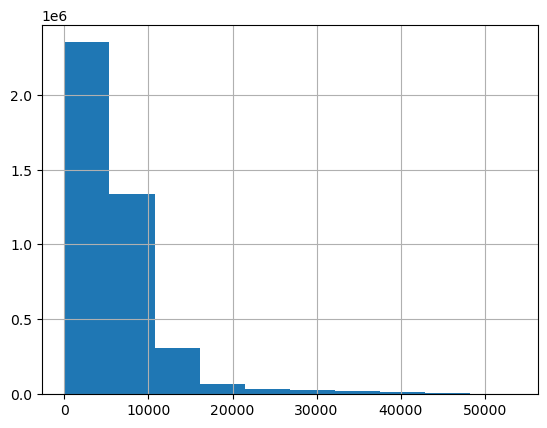

In [241]:
df_REE_gpd['min_dist_to_MS_intersections'].hist()

In [243]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin

gdf = df_REE_gpd
value_column = 'min_dist_to_MS_intersections'

pixel_size = 100  
minx, miny, maxx, maxy = df_REE_gpd.total_bounds  
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)
transform = from_origin(minx, maxy, pixel_size, pixel_size)  
out_shape = (height, width)


shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_column]))

raster = rasterize(shapes=shapes, out_shape=out_shape, transform=transform)

with rasterio.open(
    'dist_to_MS_intersections.tif',
    'w',
    driver='GTiff',
    height=out_shape[0],
    width=out_shape[1],
    count=1,
    dtype=raster.dtype,
    crs=gdf.crs,
    transform=transform
) as dst:
    dst.write(raster, 1)


In [249]:
from shapely.geometry import shape

points = [shape(geom) for geom in df_REE_gpd['geometry'] if geom is not None]
points2 = [shape(geom) for geom in df_carbonate['geometry'] if geom is not None]

In [251]:
from shapely.strtree import STRtree
import numpy as np

points = df_REE_gpd['geometry'].dropna().tolist()

tree_points_2 = STRtree(points2)



def min_distance(point, tree, geometries):
    nearest_idx = tree.nearest(point)
    nearest_geom = geometries[nearest_idx]
    return point.distance(nearest_geom)


df_REE_gpd['min_dist_to_carbonate'] = [min_distance(point, tree_points_2, points2) for point in points]

In [253]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin

gdf = df_REE_gpd
value_column = 'min_dist_to_carbonate'

pixel_size = 100  
minx, miny, maxx, maxy = df_REE_gpd.total_bounds  
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)
transform = from_origin(minx, maxy, pixel_size, pixel_size) 
out_shape = (height, width)


shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_column]))

raster = rasterize(shapes=shapes, out_shape=out_shape, transform=transform)

with rasterio.open(
    'dist_to_carbonate.tif',
    'w',
    driver='GTiff',
    height=out_shape[0],
    width=out_shape[1],
    count=1,
    dtype=raster.dtype,
    crs=gdf.crs,
    transform=transform
) as dst:
    dst.write(raster, 1)


CRS: EPSG:32643
Bounds: BoundingBox(left=607550.0, bottom=1521350.0, right=796350.0, top=1742650.0)


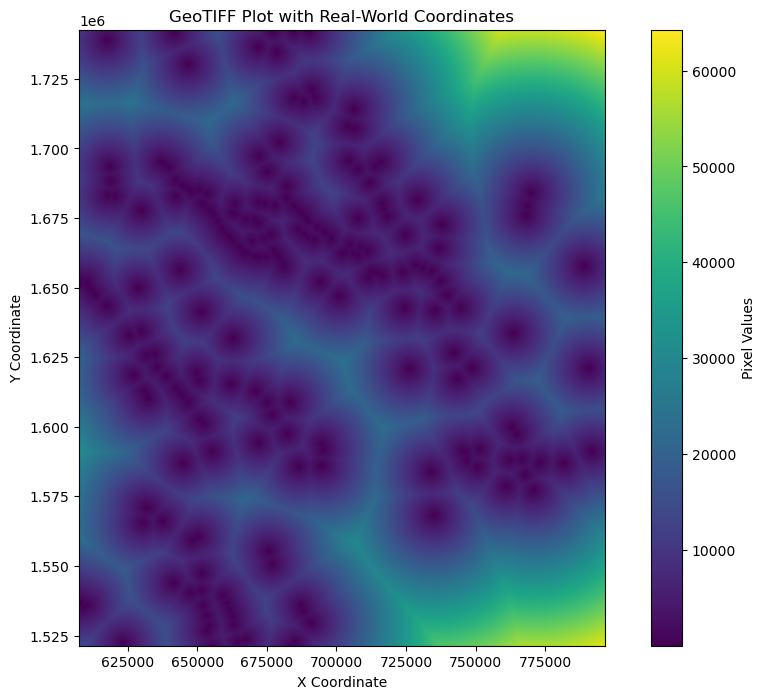

In [255]:
import numpy as np
with rasterio.open('dist_to_carbonate.tif') as src:
    raster_data = src.read(1)  
    nodata = src.nodata
    bounds = src.bounds  
    if nodata is not None:
        raster_data = np.where(raster_data == nodata, np.nan, raster_data)
    crs = src.crs         
    print(f"CRS: {crs}")
    print(f"Bounds: {bounds}")

    plt.figure(figsize=(12, 8))
    plt.imshow(
        raster_data,
        cmap='viridis',
        extent=[bounds.left, bounds.right, bounds.bottom, bounds.top]
    )
    plt.colorbar(label='Pixel Values')
    plt.title('GeoTIFF Plot with Real-World Coordinates')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

In [ ]:
########## Reading the final merged file ###############

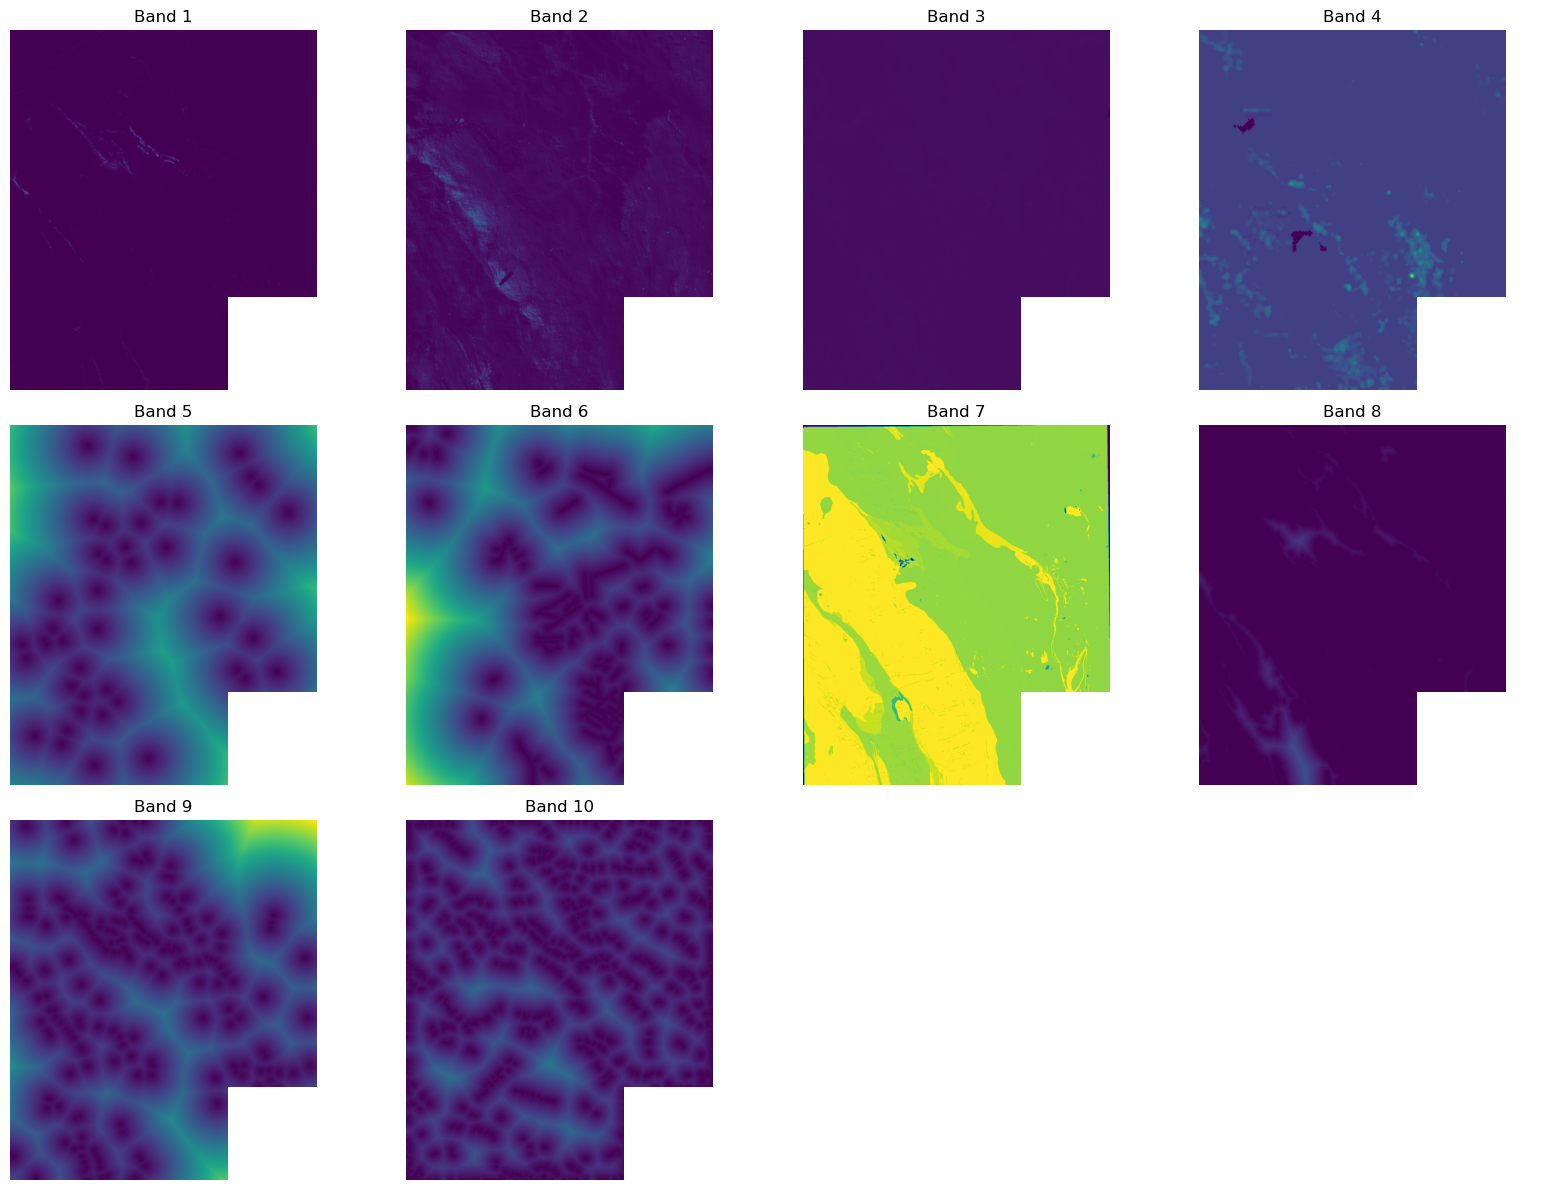

In [11]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

with rasterio.open("GEOTIFF_REE/REE_combined_mod.tif") as src:
    band_count = src.count
    nodata = src.nodata
    bands = []

    for i in range(1, band_count + 1):
        band = src.read(i).astype('float32')  
        if nodata is None:
            band = np.where(band == nodata, np.nan, band)
        
        bands.append(band)

cols = 4
rows = int(np.ceil(len(bands) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

for i, band in enumerate(bands):
    r, c = divmod(i, cols)
    ax = axes[r, c] if rows > 1 else axes[c]
    im = ax.imshow(band, cmap="viridis")
    ax.set_title(f"Band {i + 1}")
    ax.axis("off")

for j in range(len(bands), rows * cols):
    r, c = divmod(j, cols)
    ax = axes[r, c] if rows > 1 else axes[c]
    ax.axis("off")

plt.tight_layout()
plt.show()


In [3]:
import rasterio
from rasterio.windows import from_bounds
import numpy as np

xmin, ymin, xmax, ymax = 742386, 1521300, 796417.39, 1578150

with rasterio.open('GEOTIFF_REE/REE_combined_mod.tif', 'r+') as src:
    window = from_bounds(xmin, ymin, xmax, ymax, transform=src.transform)
    
    nodata = src.nodata
    if nodata is None:
        nodata = np.nan  # or np.nan
        src.nodata = nodata


    data = src.read(window=window)
    
    data[:] = nodata
    
    src.write(data, window=window)


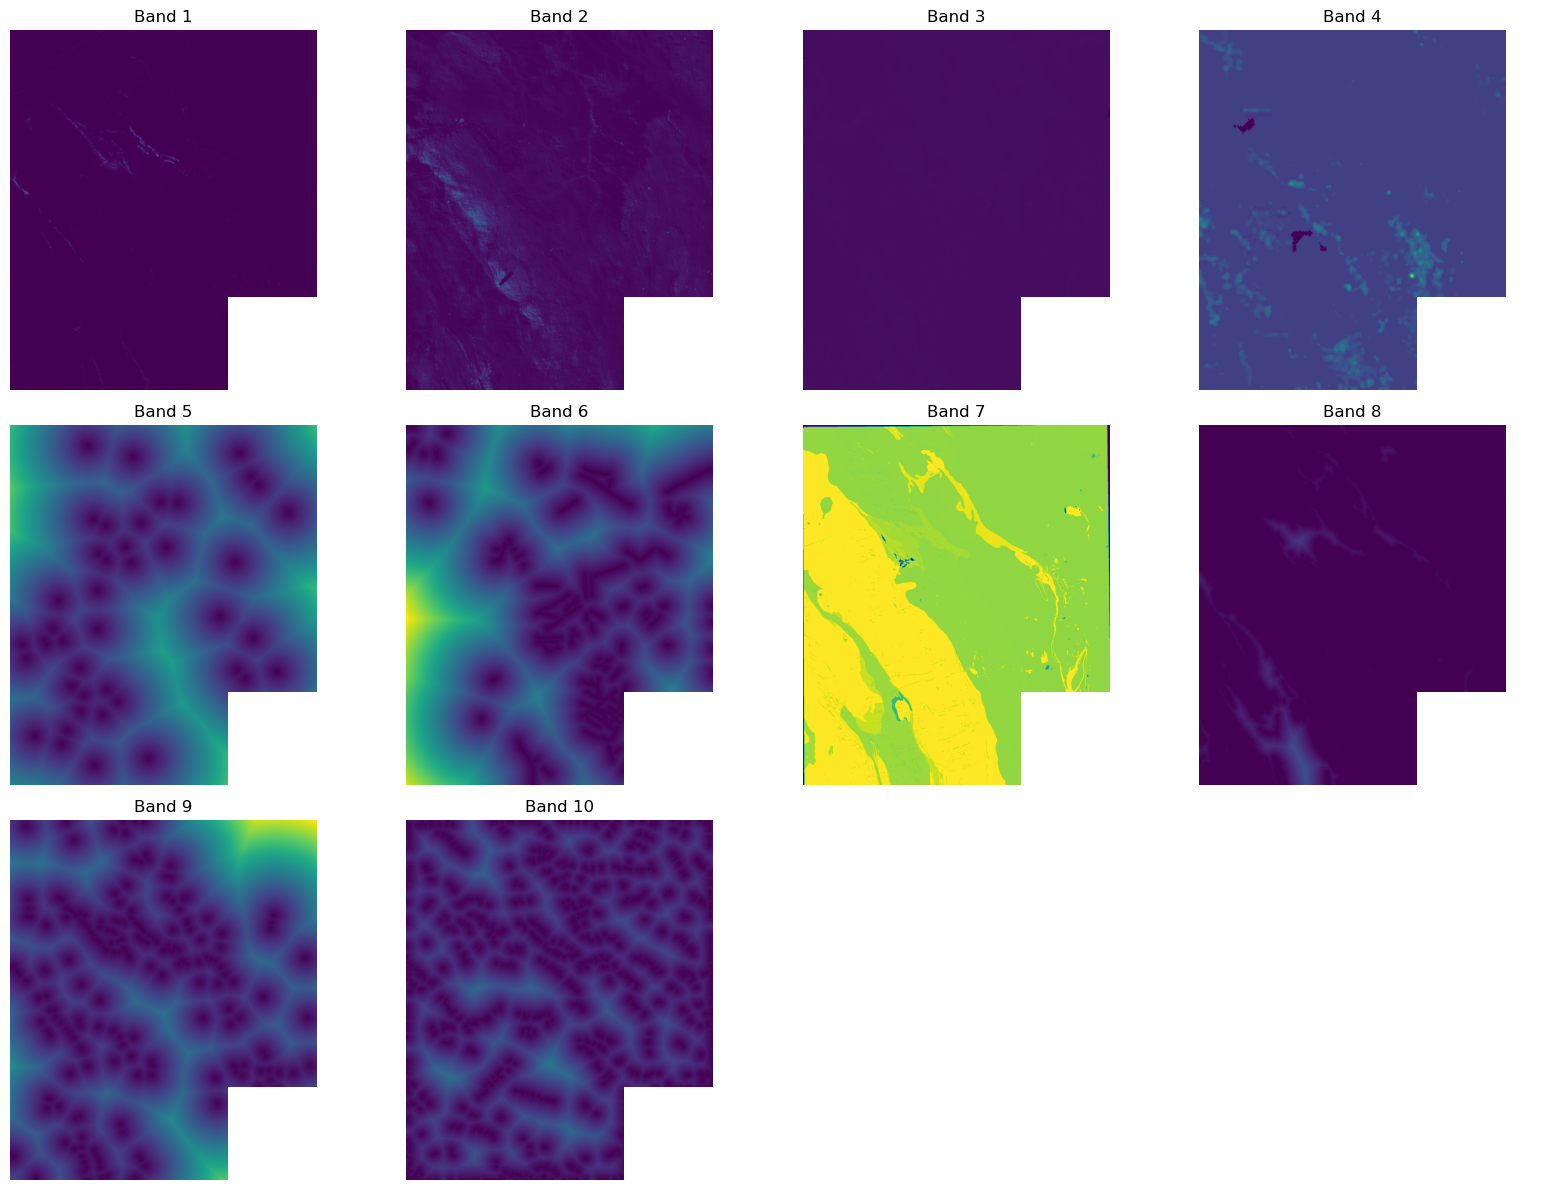

In [5]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

with rasterio.open("GEOTIFF_REE/REE_combined_mod.tif") as src:
    band_count = src.count
    nodata = src.nodata
    bands = []

    for i in range(1, band_count + 1):
        band = src.read(i).astype('float32')  
        if nodata is None:
            band = np.where(band == nodata, np.nan, band)
        #if src.nodata is not None:
        #    band[band == src.nodata] = np.nan
        bands.append(band)

cols = 4
rows = int(np.ceil(len(bands) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

for i, band in enumerate(bands):
    r, c = divmod(i, cols)
    ax = axes[r, c] if rows > 1 else axes[c]
    im = ax.imshow(band, cmap="viridis")
    ax.set_title(f"Band {i + 1}")
    ax.axis("off")

for j in range(len(bands), rows * cols):
    r, c = divmod(j, cols)
    ax = axes[r, c] if rows > 1 else axes[c]
    ax.axis("off")

plt.tight_layout()
plt.show()


In [13]:
import rasterio
import pandas as pd
from rasterio.transform import xy
import numpy as np

with rasterio.open("GEOTIFF_REE/REE_combined.tif") as src:
    band_count = src.count
    bands = [src.read(i + 1).flatten() for i in range(band_count)]  
    rows, cols = src.shape  

    coords = [xy(src.transform, row, col) for row in range(rows) for col in range(cols)]
    xs, ys = zip(*coords)

data = {
    "Longitude": xs,
    "Latitude": ys,
}

for i, band in enumerate(bands, 1):
    data[f"Band_{i}"] = band

df_REE_combined = pd.DataFrame(data)

In [15]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


def load_geotiff(file_path):
    with rasterio.open(file_path) as src:
        data = src.read()  # Read all bands
        profile = src.profile  # Store metadata
    return data, profile

file_path = "GEOTIFF_REE/REE_combined.tif"
data, profile = load_geotiff(file_path)

data_reshaped = data.reshape(data.shape[0], -1).T  
data_cleaned = data_reshaped[~np.isnan(data_reshaped).any(axis=1)]  

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_cleaned)


In [17]:
data_scaled

array([[0.        , 0.49995452, 0.        , ..., 0.01910291, 0.16575299,
        0.02207904],
       [0.        , 0.49995452, 0.        , ..., 0.01909373, 0.16428722,
        0.02199991],
       [0.        , 0.49995452, 0.        , ..., 0.01908455, 0.16282313,
        0.02207904],
       ...,
       [0.        , 0.49995452, 0.        , ..., 0.9957713 , 0.9559754 ,
        0.99592483],
       [0.        , 0.49995452, 0.        , ..., 0.99765885, 0.9566196 ,
        0.9977924 ],
       [0.        , 0.49995452, 0.        , ..., 0.99954635, 0.957266  ,
        0.9996601 ]], dtype=float32)

In [19]:
data_scaled.shape

(3875526, 14)

In [21]:
som = MiniSom(x = 5, y = 5, input_len = data_scaled.shape[1], sigma = 0.5, learning_rate = 0.5,neighborhood_function='gaussian', random_seed=42)

In [23]:
som.random_weights_init(data_scaled)

In [25]:
som.train_random(data_scaled, num_iteration=1000)

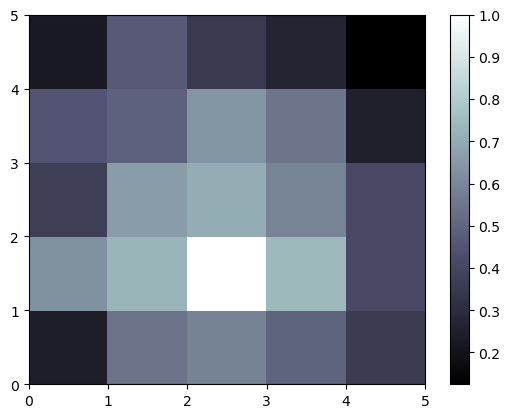

In [27]:
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']


show()

In [29]:
winner_coordinates = np.array([som.winner(x) for x in data_scaled])

In [31]:
cluster_map = np.ravel_multi_index(winner_coordinates.T, (5,5))


In [33]:
clustered_raster = np.full(data_reshaped.shape[0], np.nan)  
clustered_raster[~np.isnan(data_reshaped).any(axis=1)] = cluster_map  
clustered_raster = clustered_raster.reshape(profile["height"], profile["width"])

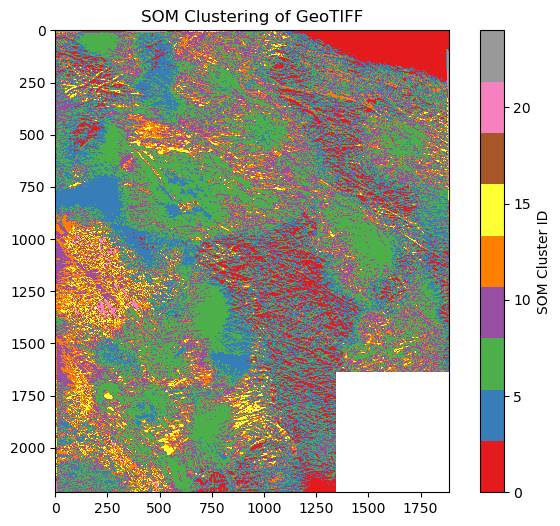

In [35]:
plt.figure(figsize=(8, 6))
plt.imshow(clustered_raster, cmap="Set1")
plt.colorbar(label="SOM Cluster ID")
plt.title("SOM Clustering of GeoTIFF")
plt.show()

In [37]:
df_REE_combined.isna().sum()

Longitude         0
Latitude          0
Band_1       306720
Band_2       306720
Band_3       306720
Band_4       306720
Band_5       306720
Band_6       306720
Band_7       306720
Band_8       306720
Band_9       306720
Band_10      306720
Band_11      306720
Band_12      306720
Band_13      306720
Band_14      306720
dtype: int64

In [39]:
df_REE_combined = df_REE_combined.dropna()

In [41]:
import numpy as np


winners = np.array([som.winner(x) for x in data_scaled])


cluster_map = {(i, j): f'Cluster{i * 5 + j}' for i in range(5) for j in range(5)}


clusters = np.array([cluster_map[tuple(w)] for w in winners])


df_REE_combined['Cluster'] = clusters

In [51]:
import geopandas as gpd
df_REE_combined_gdf = gpd.GeoDataFrame(df_REE_combined, geometry=gpd.points_from_xy(df_REE_combined.Longitude, df_REE_combined.Latitude), crs="EPSG:32643")

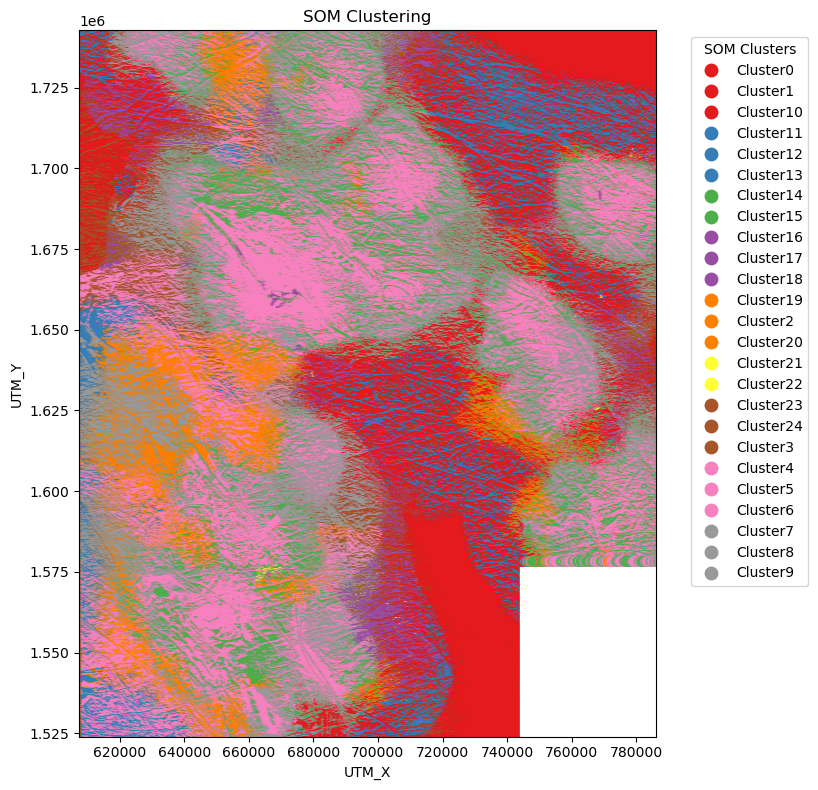

In [69]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))


df_ree_min.plot(ax=ax, color = 'black', label="Known REE Mineralization")
df_REE_combined_gdf.plot(ax=ax, column='Cluster', cmap='Set1', legend=True)


ax.set_xlabel("UTM_X")
ax.set_ylabel("UTM_Y")
ax.set_title("SOM Clustering")


ax.set_xlim(607500, 786000)
ax.set_ylim(1524000, 1742700)


legend = ax.get_legend()
if legend:
    legend.set_bbox_to_anchor((1.05, 1))
    legend.set_title("SOM Clusters")


plt.tight_layout()
plt.savefig("SOM_REE.jpg")
plt.show()


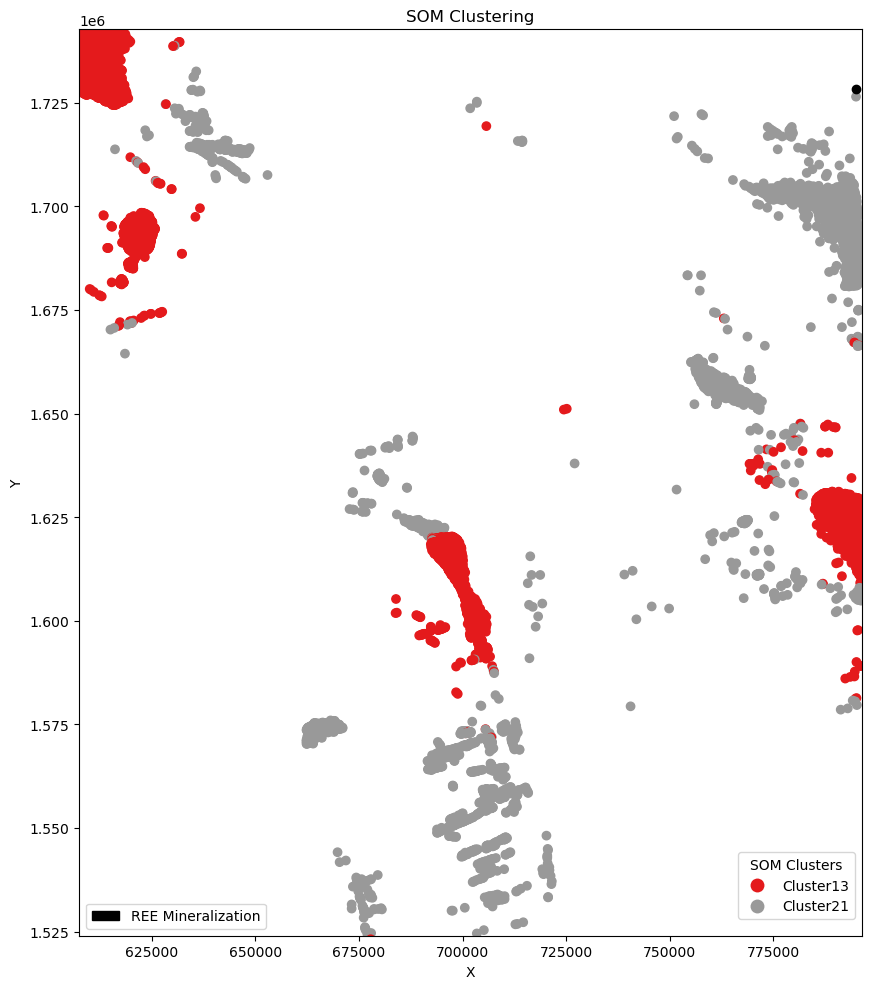

In [97]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 10))

df_REE_combined_gdf[(df_REE_combined_gdf['Cluster']=='Cluster21')|(df_REE_combined_gdf['Cluster']=='Cluster13')].plot(ax=ax, column='Cluster', cmap='Set1', legend=True)
df_ree_min.plot(ax=ax, color = 'black',label= "REE Mineralization", legend=True)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("SOM Clustering")

ax.set_xlim(607500, 796350)
ax.set_ylim(1524000, 1742700)

cluster_legend = ax.get_legend()
if cluster_legend:
    cluster_legend.set_title("SOM Clusters")
    cluster_legend.set_bbox_to_anchor((1, 0.1))
    cluster_legend.set_frame_on(True)
    ax.add_artist(cluster_legend)  

min_patch = mpatches.Patch(color='black', label='REE Mineralization')
ax.legend(handles=[min_patch], loc='lower left')
plt.tight_layout()
plt.savefig("REE_clusters.jpg", bbox_inches='tight')
plt.show()

In [57]:
df_REE_final = df_REE_combined_gdf[(df_REE_combined_gdf['Cluster']=='Cluster21')|(df_REE_combined_gdf['Cluster']=='Cluster13')]

In [59]:
df_REE_final = df_REE_final[['Longitude','Latitude','Cluster','geometry']]

In [61]:
df_REE_final.crs

<Projected CRS: EPSG:32643>
Name: WGS 84 / UTM zone 43N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 72°E and 78°E, northern hemisphere between equator and 84°N, onshore and offshore. China. India. Kazakhstan. Kyrgyzstan. Maldives. Pakistan. Russian Federation. Tajikistan.
- bounds: (72.0, 0.0, 78.0, 84.0)
Coordinate Operation:
- name: UTM zone 43N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

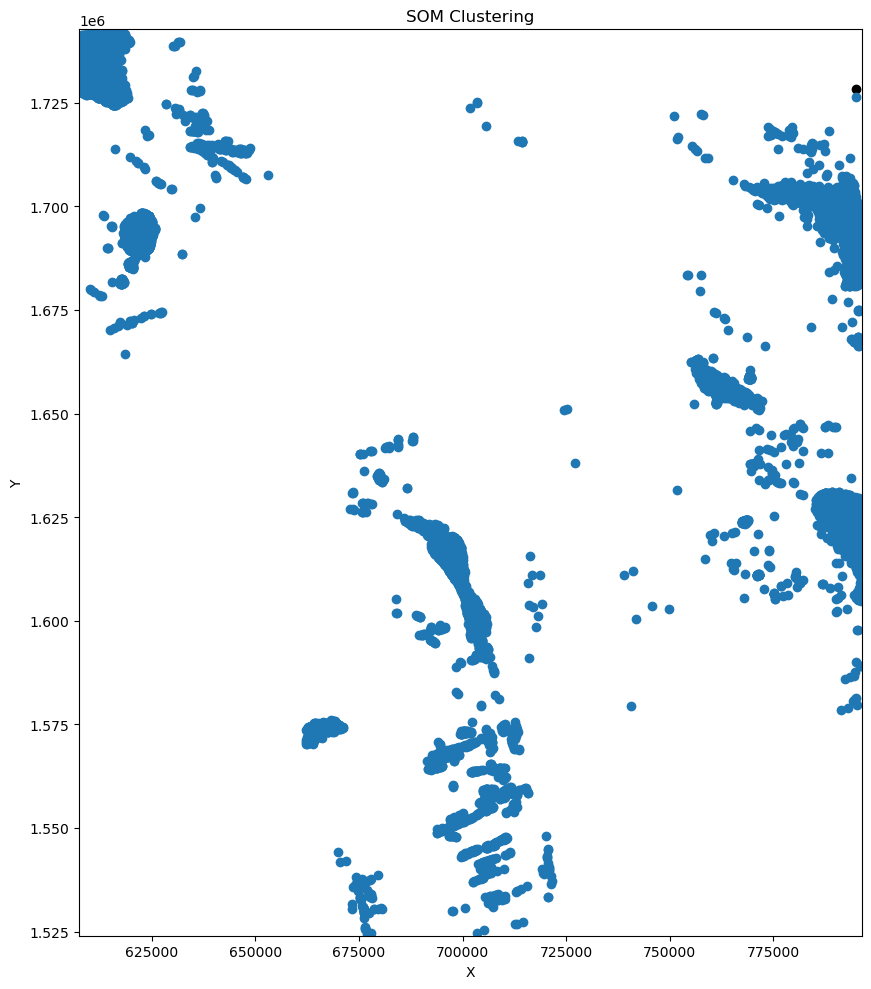

In [63]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))


df_ree_min.plot(ax=ax, color = 'black')
df_REE_final.plot(ax=ax)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("SOM Clustering")

# Set axis limits
ax.set_xlim(607500, 796350)
ax.set_ylim(1524000, 1742700)

# Adjust legend placement
legend = ax.get_legend()
if legend:
    legend.set_bbox_to_anchor((1.05, 1))
    legend.set_title("SOM Clusters")

# Optional: tidy layout to prevent clipping
plt.tight_layout()

plt.show()


In [65]:
df_REE_final.to_file("REE_cluster.shp")
